## Research Question

What features (columns) are important to predict whether a patient is not going to show up to their scheduled medical appointment?

## Import statements

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

/Users/ammarjawaddoosh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Exploratory Data Analysis and Data Wrangling

In [2]:
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [4]:
print ("Rows: ", df.shape[0])
print ("Columns: ", df.shape[1])
df.head()

Rows:  110527
Columns:  14


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Notice that values for "Gender" and "No-show" are strings instead of bool. These will need to be transformed  before they can be used as features for machine learning. There's also an opportunity to do One-Hot encoding on "Neighbourhood" to split each variable into a feature for machine learning.

In [5]:
df.isnull().any()

PatientId         False
AppointmentID     False
Gender            False
ScheduledDay      False
AppointmentDay    False
Age               False
Neighbourhood     False
Scholarship       False
Hipertension      False
Diabetes          False
Alcoholism        False
Handcap           False
SMS_received      False
No-show           False
dtype: bool

There are no null-values in the dataset which indicates it has already been cleaned for missing values.

In [6]:
# Replace 'M' and 'F' with 1 and 0 for 'Gender' and 'Yes' and 'No'
# with 1 and 0 for 'No-show'
df['Gender'] = df['Gender'].map({'M':1, 
                                 'F':0}
                               )
df['No-show'] = df['No-show'].map({'Yes':1, 
                                   'No':0}
                                 )

In [7]:
# Renaming columns to fix typos, inconsistency and spelling mistakes
df.rename(columns={'AppointmentID':'AppointmentId',
                   'Handcap':'Handicap', 
                   'Hipertension':'Hypertension'}, 
          inplace=True
         )

df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0


Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: 

0    88208
1    22319
Name: No-show, dtype: int64

 Out of 110527 records, 22319 didn't show up, i.e. 20.19 %


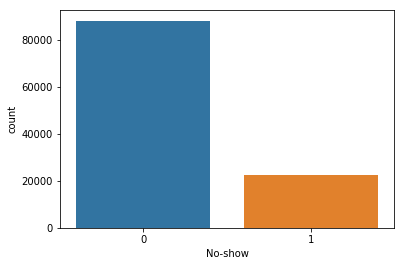

In [12]:
def no_show_class():
    '''Count the values of No-show to spot whether classes are imbalanced or not'''
    no_show = 0
    for value in df['No-show']:
        if value == 1:
            no_show += 1
    print ("\n Out of", len(df['No-show']), "records,", no_show, "didn't show up, i.e.", round(float(no_show) / float(len(df['No-show'])), 4)*100,"%")

print ("Below is the split of values in 'No-show': 0 = showed up and 1 = didn't show up: \n")
print (df['No-show'].value_counts())
sns.countplot(x='No-show', data=df)

no_show_class()

Classes of 'No-show' are imbalanced and something we have to take into account when the dataset is going to be split into train and test. A stratified shuffle split is likely going to be ideal for cross-validating our machine learning model due to its randomised validations to increase the likelihood of the imbalanced classes for cross validation.

In [14]:
# Checking the range for 'Age' to spot outliers
print ("Age range: ", sorted(df['Age'].unique()))

Age range:  [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 115]


The youngest patient is -1 years old and the oldest is 115. It is clear the the youngest patient has to be removed since it's an impossibility and an outlier in our machine learning model. Likewise with patients older than 100. However, there may be outliers within the range so further exploration is required.

Text(0.5,1,'Distribution of Age')

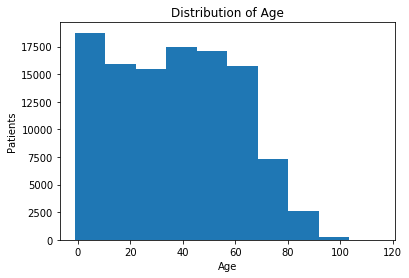

In [15]:
# Distribution of 'Age'
plt.figure();
age_hist = df['Age'].plot.hist(bins=10)
age_hist.set_xlabel("Age")
age_hist.set_ylabel("Patients")
age_hist.set_title('Distribution of Age')

It is apparent from the histogram above that patients aged above 90 are few and outliers.

In [17]:
# Only keep records of patients where they are between 0-90 in age to remove outliers.
df = df[(df.Age >= 0) & (df.Age <= 90)]

min_age = df['Age'].min()
max_age = df['Age'].max()
print ("Age now spans values from: {} to {}.".format(min_age, max_age))

Age now spans values from: 0 to 90.


Distribution of patients by Gender: 

Female: 71619 
Male: 38599


Text(0.5,1,'Distribution of Gender')

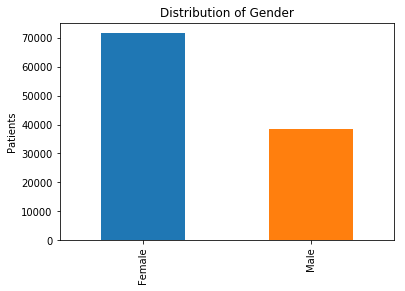

In [19]:
# Gender split
print ("Distribution of patients by Gender: \n")
print ("Female: {} \nMale: {}".format(df['Gender'].value_counts()[0], df['Gender'].value_counts()[1]) )

# Plotting gender distribution
gender_bar = df['Gender'].value_counts().plot.bar()
gender_bar.set_xticklabels(["Female", "Male"])
gender_bar.set_ylabel("Patients")
gender_bar.set_title('Distribution of Gender')

## Feature Engineering

In [20]:
# Transforming ScheduledDay and AppointmentDay into datetime objects and stripping hours, minutes and seconds.
dt_scheduledDay =  pd.to_datetime(df.ScheduledDay).dt.date
dt_appointmentDay = pd.to_datetime(df.AppointmentDay).dt.date

# Storing "delta_days" to df as a new feature
df['Days_delta'] = (dt_appointmentDay - dt_scheduledDay).dt.days
df.head()

,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,Days_delta
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0


/Users/ammarjawaddoosh/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


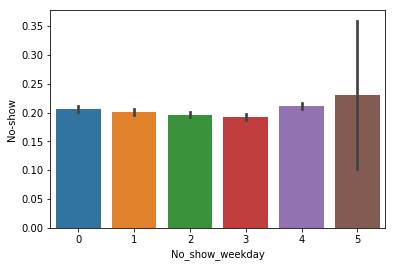

In [122]:
# Changing AppointmentDay to a datetime pandas object to create a new dayofweek engineered feature
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df['No_show_weekday'] = df['AppointmentDay'].dt.dayofweek
#df['No_show_weekday'] = df[['No-show', 'No_show_weekday']].groupby('No_show_weekday').mean()
#df['No_show_weekday'].sample(5)
sns.barplot(y='No-show', x='No_show_weekday', data=df)

The highest proportion of no-shows coincide with when the appointment day happens to be on a Friday or Saturday. An explanation for why there's no data for Sundays could be that the clinic is closed.

In [123]:
# Exploring features and content to spot identifiers and to separate categorical from numerical columns for modelling later
print ("PatientIds: ", len(df.PatientId.unique()))
print ("\nAppointmentIds: ", len(df.AppointmentId.unique()))
print ("\nNo. of appointment days: ", len(df.AppointmentDay.unique()))
print ("\nGender: ", df.Gender.unique())
print ("\nAge: ", sorted(df.Age.unique()), "\n Unique values: ", len(df.Age.unique()))
print ("\nSMS_received: ", df.SMS_received.unique())
print ("\nScholarship: ", df.Scholarship.unique())
print ("\nHypertension: ", df.Hypertension.unique())
print ("\nDiabetes: ", df.Diabetes.unique())
print ("\nAlcoholism: ", df.Alcoholism.unique())
print ("\nHandicap: ", df.Handicap.unique())
print ("\nNo-show: ", df["No-show"].unique())
print ("\nDays delta: ", sorted(df.Days_delta.unique()))
print ("\nBrazilian neighbourhoods: ", len(df.Neighbourhood.unique()))

PatientIds:  61691

AppointmentIds:  109345

No. of appointment days:  27

Gender:  [0 1]

Age:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90] 
 Unique values:  91

SMS_received:  [0 1]

Scholarship:  [0 1]

Hypertension:  [1 0]

Diabetes:  [0 1]

Alcoholism:  [0 1]

Handicap:  [0 1 2 3 4]

No-show:  [0 1]

Days delta:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]

Brazilian neighbourhoods:  81


Text(0.5,1,'Distribution of Days delta')

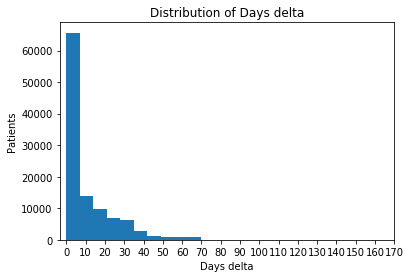

In [94]:
# days_delta contains impossible values such as -6 and -1 
# which look like mistakes/outliers but require further investigation.

days_hist = df['Days_delta'].plot.hist(bins=10)
days_hist.set_xlabel("Days delta")
days_hist.set_xticks(range(0, 180, 10))
days_hist.set_ylabel("Patients")
days_hist.set_title('Distribution of Days delta')

In [95]:
# days_delta < 0 and > 90 are not on the histogram which indicates that they don't belong to a patient/few patients and therefore should be removed.
df = df[(df.Days_delta >= 0) & (df.Days_delta <= 70)]
print ("Days delta: ", sorted(df.Days_delta.unique()))

Days delta:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]


In [36]:
# Creating vars to hold categorical features for one hot encoding
cat_features_for_encoding = ['Handicap', 'Neighbourhood']

# Creating var for all numerical features in case we want to deep dive to identify
# which age and what days delta are the most important in predicting "No-show" outcome
num_features_for_encoding = ['Age', 'Days_delta'] 

In [40]:
# One-Hot encoding on categorical columns to prepare dataset for machine learning modelling.
encoded_df = pd.get_dummies(df, columns=cat_features_for_encoding)
print ("New encoded dataframe has {} rows and {} features.".format(encoded_df.shape[0], encoded_df.shape[1]))

# Increasing the max column shown for this cell to 100
pd.set_option("max_columns", 100)

encoded_df.head()

New encoded dataframe has 109345 rows and 99 features.


,PatientId,AppointmentId,Gender,ScheduledDay,AppointmentDay,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMS_received,No-show,Days_delta,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4,Neighbourhood_AEROPORTO,Neighbourhood_ANDORINHAS,Neighbourhood_ANTÔNIO HONÓRIO,Neighbourhood_ARIOVALDO FAVALESSA,Neighbourhood_BARRO VERMELHO,Neighbourhood_BELA VISTA,Neighbourhood_BENTO FERREIRA,Neighbourhood_BOA VISTA,Neighbourhood_BONFIM,Neighbourhood_CARATOÍRA,Neighbourhood_CENTRO,Neighbourhood_COMDUSA,Neighbourhood_CONQUISTA,Neighbourhood_CONSOLAÇÃO,Neighbourhood_CRUZAMENTO,Neighbourhood_DA PENHA,Neighbourhood_DE LOURDES,Neighbourhood_DO CABRAL,Neighbourhood_DO MOSCOSO,Neighbourhood_DO QUADRO,Neighbourhood_ENSEADA DO SUÁ,Neighbourhood_ESTRELINHA,Neighbourhood_FONTE GRANDE,Neighbourhood_FORTE SÃO JOÃO,Neighbourhood_FRADINHOS,Neighbourhood_GOIABEIRAS,Neighbourhood_GRANDE VITÓRIA,Neighbourhood_GURIGICA,Neighbourhood_HORTO,Neighbourhood_ILHA DAS CAIEIRAS,Neighbourhood_ILHA DE SANTA MARIA,Neighbourhood_ILHA DO BOI,Neighbourhood_ILHA DO FRADE,Neighbourhood_ILHA DO PRÍNCIPE,Neighbourhood_ILHAS OCEÂNICAS DE TRINDADE,Neighbourhood_INHANGUETÁ,Neighbourhood_ITARARÉ,Neighbourhood_JABOUR,Neighbourhood_JARDIM CAMBURI,Neighbourhood_JARDIM DA PENHA,Neighbourhood_JESUS DE NAZARETH,Neighbourhood_JOANA D´ARC,Neighbourhood_JUCUTUQUARA,Neighbourhood_MARIA ORTIZ,Neighbourhood_MARUÍPE,Neighbourhood_MATA DA PRAIA,Neighbourhood_MONTE BELO,Neighbourhood_MORADA DE CAMBURI,Neighbourhood_MÁRIO CYPRESTE,Neighbourhood_NAZARETH,Neighbourhood_NOVA PALESTINA,Neighbourhood_PARQUE INDUSTRIAL,Neighbourhood_PARQUE MOSCOSO,Neighbourhood_PIEDADE,Neighbourhood_PONTAL DE CAMBURI,Neighbourhood_PRAIA DO CANTO,Neighbourhood_PRAIA DO SUÁ,Neighbourhood_REDENÇÃO,Neighbourhood_REPÚBLICA,Neighbourhood_RESISTÊNCIA,Neighbourhood_ROMÃO,Neighbourhood_SANTA CECÍLIA,Neighbourhood_SANTA CLARA,Neighbourhood_SANTA HELENA,Neighbourhood_SANTA LUÍZA,Neighbourhood_SANTA LÚCIA,Neighbourhood_SANTA MARTHA,Neighbourhood_SANTA TEREZA,Neighbourhood_SANTO ANDRÉ,Neighbourhood_SANTO ANTÔNIO,Neighbourhood_SANTOS DUMONT,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
0,2.987250e+13,5642903,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5.589978e+14,5642503,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.262962e+12,5642549,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,8.679512e+11,5642828,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,8.841186e+12,5642494,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Feature Selection


In [42]:
# Dropping all varchar/date features including labels from df
features = encoded_df.drop(['No-show', 'PatientId', 'AppointmentId', 'ScheduledDay', 'AppointmentDay'], axis=1)

# labels refers to "No-show" as they are the classes to predict
labels = encoded_df['No-show']
print (labels.head())
features.head()

0    0
1    0
2    0
3    0
4    0
Name: No-show, dtype: int64


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,SMS_received,Days_delta,Handicap_0,Handicap_1,Handicap_2,Handicap_3,Handicap_4,Neighbourhood_AEROPORTO,Neighbourhood_ANDORINHAS,Neighbourhood_ANTÔNIO HONÓRIO,Neighbourhood_ARIOVALDO FAVALESSA,Neighbourhood_BARRO VERMELHO,Neighbourhood_BELA VISTA,Neighbourhood_BENTO FERREIRA,Neighbourhood_BOA VISTA,Neighbourhood_BONFIM,Neighbourhood_CARATOÍRA,Neighbourhood_CENTRO,Neighbourhood_COMDUSA,Neighbourhood_CONQUISTA,Neighbourhood_CONSOLAÇÃO,Neighbourhood_CRUZAMENTO,Neighbourhood_DA PENHA,Neighbourhood_DE LOURDES,Neighbourhood_DO CABRAL,Neighbourhood_DO MOSCOSO,Neighbourhood_DO QUADRO,Neighbourhood_ENSEADA DO SUÁ,Neighbourhood_ESTRELINHA,Neighbourhood_FONTE GRANDE,Neighbourhood_FORTE SÃO JOÃO,Neighbourhood_FRADINHOS,Neighbourhood_GOIABEIRAS,Neighbourhood_GRANDE VITÓRIA,Neighbourhood_GURIGICA,Neighbourhood_HORTO,Neighbourhood_ILHA DAS CAIEIRAS,Neighbourhood_ILHA DE SANTA MARIA,Neighbourhood_ILHA DO BOI,Neighbourhood_ILHA DO FRADE,Neighbourhood_ILHA DO PRÍNCIPE,Neighbourhood_ILHAS OCEÂNICAS DE TRINDADE,Neighbourhood_INHANGUETÁ,Neighbourhood_ITARARÉ,Neighbourhood_JABOUR,Neighbourhood_JARDIM CAMBURI,Neighbourhood_JARDIM DA PENHA,Neighbourhood_JESUS DE NAZARETH,Neighbourhood_JOANA D´ARC,Neighbourhood_JUCUTUQUARA,Neighbourhood_MARIA ORTIZ,Neighbourhood_MARUÍPE,Neighbourhood_MATA DA PRAIA,Neighbourhood_MONTE BELO,Neighbourhood_MORADA DE CAMBURI,Neighbourhood_MÁRIO CYPRESTE,Neighbourhood_NAZARETH,Neighbourhood_NOVA PALESTINA,Neighbourhood_PARQUE INDUSTRIAL,Neighbourhood_PARQUE MOSCOSO,Neighbourhood_PIEDADE,Neighbourhood_PONTAL DE CAMBURI,Neighbourhood_PRAIA DO CANTO,Neighbourhood_PRAIA DO SUÁ,Neighbourhood_REDENÇÃO,Neighbourhood_REPÚBLICA,Neighbourhood_RESISTÊNCIA,Neighbourhood_ROMÃO,Neighbourhood_SANTA CECÍLIA,Neighbourhood_SANTA CLARA,Neighbourhood_SANTA HELENA,Neighbourhood_SANTA LUÍZA,Neighbourhood_SANTA LÚCIA,Neighbourhood_SANTA MARTHA,Neighbourhood_SANTA TEREZA,Neighbourhood_SANTO ANDRÉ,Neighbourhood_SANTO ANTÔNIO,Neighbourhood_SANTOS DUMONT,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM
0,0,62,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,56,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,56,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Validation

In [43]:
# Splitting dataset into train and test for features and labels
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=60)

In [44]:
# Setting up CV using stratifiedshufflesplit due to class imbalance of No-show.
cv = StratifiedShuffleSplit(n_splits=15, test_size=0.2, random_state=60)

## Feature Importances

In [46]:
# Fitting a tree
clf = tree.DecisionTreeClassifier(random_state=60)
clf.fit(features_train, labels_train)

# Feature Importances to see whether new feature created has any importance.
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print ("Feature ranking: ")
for i in range(1, 11, 1):
    print ("  {}.  feature: {} ({})".format(i, features_train.columns[i], importances[indices[i]]))

Feature ranking: 
  1.  feature: Age (0.2772811496511538)
  2.  feature: Scholarship (0.053734219090301925)
  3.  feature: Hypertension (0.022269309794157865)
  4.  feature: Diabetes (0.019564082342115173)
  5.  feature: Alcoholism (0.01873693161844271)
  6.  feature: SMS_received (0.013113162862411484)
  7.  feature: Days_delta (0.010070213480179281)
  8.  feature: Handicap_0 (0.00993452029963806)
  9.  feature: Handicap_1 (0.009555603019364449)
  10.  feature: Handicap_2 (0.008826049517397063)


As is evident from the feature importances above the most important features are Age (0.27), Scholarship (0.05), Hypertension (0.02), Diabetes (0.01) and Alcoholism (0.01) and the other feature importances drop significantly below the top 5. However, because no One-Hot encoding has been applied to Age as a feature, we won't know which which particular age is the most important for predicting whether patients will show up or not. Due to how big importance age has scored, it may be better to One-Hot encode that feature if the model doesn't perform well.

### SelectPercentile using Chi2

Chi squared is chosen as the scoring function due to the nature of the dataset. There are no negative values in the features nor in labels and the majority of features are bools which makes it ideal for chi squared scoring. It discards features that are independent of "No-show" and therefore irrelevant for classification and a list is returned with scores for each feature. 

In [52]:
# SelectPercentile to identify best features
selector = SelectPercentile(chi2)
selector.fit_transform(features_train, labels_train)

# Storing best features and their stores in separate pd.Series
scores = pd.Series(selector.scores_)
columns = pd.Series(features_train.columns)

# Concatenating both pd.Series into one df
selectbest = pd.concat([columns, scores], axis=1)
selectbest.rename(columns={0:'features',
                   1:'scores'}, inplace=True)

/Users/ammarjawaddoosh/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'Score')

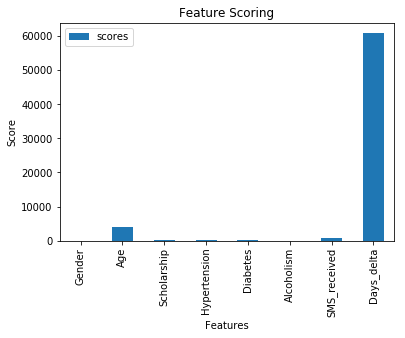

In [76]:
# Visualizing best features using chi squared and their scores each
selectbest_plot = selectbest.iloc[:8,:].plot.bar()
selectbest_plot.set_title('Feature Scoring')
selectbest_plot.set_xticklabels(selectbest['features'])
selectbest_plot.set_xlabel('Features')
selectbest_plot.set_ylabel('Score')

However, when using SelectPercentile to identify the top 8 percent features using Chi-squared we get a different set of features. Here days_delta, Age and SMS_received are scored the highest. These parameters are easier to intuitively understand and more sensible to play an important role in predicting whether a patient is going to be a no-show or not.
Intuitively, a patient cancelling due to too many days having passed from when they initially booked an appointment until they got it makes sense. It is also more intuitive that age plays a role on No-show, e.g. teens and elders. Finally, whether a patient received a reminder about an upcoming appointment or not will at least remind those who have forgotten about it and therefore likely to be an important feature and vice versa (patients that have not received a message may forget their appointment and not show up).

Based on the above reasoning, feature selection will be done using Chi-squared's SelectPercentile function.

In [78]:
# Top features based on different methods
best_chi_features = ['Days_delta', 'Age', 'SMS_received']
best_features_importances = ['Age', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism']
combined_best_features = ['Days_delta', 'Age', 'SMS_received', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism']

## Null Accuracy

In [79]:
# Distribution of classes in the test labels
labels_test.value_counts()

0    26197
1     6607
Name: No-show, dtype: int64

In [81]:
# Proportion of classes that didn't show
print ("Patients who didn't show up: ", labels_test.mean())
print ("Patients who did show up: ", (1 - labels_test.mean()))

# Null Accuracy, ie. accuracy achieved by a dumb model if it only predicted a patient would show up to an appointment
print ("\nNull accuracy is therefore ", max(labels_test.mean(), 1 - labels_test.mean()))

Patients who didn't show up:  0.2014083648335569
Patients who did show up:  0.798591635166443

Null accuracy is therefore  0.798591635166443


The null accuracy tells us what the minimum accuracy should be for our models. If a dumb model was designed to only predict the outcome based on the most frequently occuring class, i.e. patients who did show up then it would be right 80% of the time.

Any model we design has to perform better than 80% in accuracy. However, due to the imbalanced classes it may be wise to tune hyperparameters for the f-score.

## Fine-tuning Hyperparameters

In [84]:
##############################
# Gradient Boosting Machines #
##############################

# {'n_estimators': 2175, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 1, 'max_depth': 16, 'learning_rate': 0.066}

def optimalGBMparams():
    '''Runs RandomizedSearchCV through GBM parameters to identify best parameters for a model'''
    clf = GradientBoostingClassifier(random_state=60)
    params = {'learning_rate':np.linspace(0.1, 0.001, num=10),
                  'n_estimators':np.arange(2150, 2200, 5),
                  'max_depth':np.arange(14, 18, 1),
                  'max_features':np.arange(1, 3, 1),
                  'min_samples_split':np.arange(14, 18, 1),
                  'min_samples_leaf':np.arange(1, 5, 1)
             }
    gbm_rscv = RandomizedSearchCV(clf, param_distributions=params, cv=cv, n_iter=10, scoring='accuracy', n_jobs=5, verbose=1)
    gbm_rscv.fit(features_train, labels_train)
    
    print (gbm_rscv.best_params_)
    print (gbm_rscv.best_score_)

def fitGBM():
    '''Fitting the GBM model using the best parameters from the function above'''
    clf = GradientBoostingClassifier(random_state=60,
                                    learning_rate=0.077,
                                    n_estimators=1710,
                                    max_depth=29,
                                    max_features=1,
                                    min_samples_split=12,
                                    min_samples_leaf=6
                                    )
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    
    f_gbm = f1_score(pred, labels_test)
    acc_gbm = accuracy_score(pred, labels_test)
    
    print ("F-score: ", f_gbm)
    print ("Accuracy: ", acc_gbm)

optimalGBMparams()
#fitGBM()

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 23.5min
/Users/ammarjawaddoosh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ammarjawaddoosh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ammarjawaddoosh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/ammarjawaddoosh/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'pr

{'n_estimators': 2175, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_features': 1, 'max_depth': 16, 'learning_rate': 0.066}
0.2882468789068952


In [28]:
#################
# Random Forest#
################
def optimalRFparams():
    '''Runs RandomizedSearchCV through key Random Forest hyperparameters to identify best performing params'''
    clf = RandomForestClassifier(random_state=60)
    params = {
        'n_estimators':np.arange(1000, 1400, 5),
        'max_features':np.arange(1, 20, 1),
        'min_samples_leaf':np.arange(1, 50, 1),
        'min_samples_split':np.arange(1, 50, 1),
        'class_weight':['balanced', None]
    }
    rf_rscv = RandomizedSearchCV(clf, param_distributions=params, cv=cv, n_iter=10, scoring='f1', n_jobs=10, verbose=1)
    rf_rscv.fit(features_train, labels_train)
    
    print (rf_rscv.best_params_)
    print (rf_rscv.best_score_)

def fitRF():
    '''Fitting a RF with the best params found using RandomizedSearchCV'''
    clf = RandomForestClassifier(random_state=60,
                                n_estimators=1350,
                                min_samples_split=31,
                                min_samples_leaf=6,
                                max_features=9,
                                class_weight=None)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    
    f_rf = f1_score(pred, labels_test)
    acc_rf = accuracy_score(pred, labels_test)
    
    print ("F-score: ", f_rf)
    print ("Accuracy: ", acc_rf)
    
optimalRFparams()
#fitRF()

Fitting 15 folds for each of 10 candidates, totalling 150 fits


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  9.0min
[Parallel(n_jobs=10)]: Done 150 out of 150 | elapsed: 74.3min finished


{'n_estimators': 1350, 'min_samples_split': 31, 'class_weight': None, 'max_features': 9, 'min_samples_leaf': 6}
0.798381057507


In [ ]:
# Scaling continuous features to normalise data as input for KNN
mms = MinMaxScaler()
X_train_normalised = mms.fit_transform(features_train)
X_test_normalised = mms.transform(features_test)

In [ ]:
#######
# KNN #
#######

def optimalKNNparams():
    '''Runs RandomizedSearchCV through key KNN hyperparameters to identify best performing params'''
    clf = KNeighborsClassifier()
    params = {
        'n_neighbors':np.arange(1, 30, 1),
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size':np.arange(1, 150, 1),
        'p':np.arange(1, 3, 1)
    }
    knn_rscv = RandomizedSearchCV(clf, param_distributions=params, cv=cv, n_iter=10, scoring='f1', n_jobs=10, verbose=1)
    knn_rscv.fit(X_train_normalised, labels_train)
    
    print (knn_rscv.best_params_)
    print (knn_rscv.best_score_)
    
def fitKNN():
    '''Fitting KNN with the best params found using RandomizedSearchCV'''
    clf = KNeighborsClassifier()
    clf.fit()
    
optimalKNNparams()
#fitKNN()

Fitting 15 folds for each of 10 candidates, totalling 150 fits


## Model Performance

<br>Running a RF classifier with all features post clearning/feature engineering returns an f-score of <b>0.44</b>
<br>Running a GBM classifier with all features post cleaning/feature engineering returns an f-score of <b>0.30</b>
<br> Running a GBM classifier with features from both ch2 and feature importances retruns an f-score of <b>0.24</b>
<br>Running a GBM classifier using features from chi2 returns an f-score of <b>0.11</b>.
<br>Running a GBM classifier using features from feature importances returns an f-score of <b>0.0062</b>

## Limitations

It appears that the dataset is only based on 27 unique dates worth of data spread over April, May and June (27 unique dates in AppointmentDay) and therefore it doesn't provide a representative sample for predicting whether a patient is likely to not show up on a date outside of those 27 days. If the data was based on October, November and December the conclusions drawn might have been different and the features in feature selection may also have been completely different.
<br><br>Missing features which may have been useful to this analysis could be whether a patient in the past has been a no-show, or a patient's post-code, or whether the patient is employed or unemployed or even the reason they scheduled an appointment.

## Conclusion

The most important features to predict if a patient is not going to show up to their medical appointment are different depending on what method used in feature selection. By using feature importances on a decision tree the top 5 most important features are  Age, Scholarship, Hypertension, Diabetes, and Alcoholism which are not that intuitive except for age (teenagers/elderly). However, when using SelectPercentile with chi squared the top features are days_delta (engineered feature), Age and SMS_received which sounds more intuitive and reasonable. Yet none of these features, or even a combination of top features from both chi2 and feature importances score as high as using all features post cleaning.<br>This is evident from the performance of the GBM classifier using all features compared to only the top features chi2 or feature importances or both combined. The best performing model is using Random Forests and all features post cleaning returning an f-score of 0.44.